# 01: Data Preprocessing & Initial Exploration

This notebook transforms raw text data from `jerbarnes_dataset.csv` and `crowdsourced_dataset.csv` into multiple processed versions suitable for sentiment analysis model training. `MalteseTokenizer` executes a series of text normalization steps: cleaning, anonymization, Maltese language filtering, emoji-to-text conversion, tokenization, token cleaning, configurable case folding, word normalization, and optional lemmatization.

The word normalization and lemmatization stages involve API calls to Gabra, which are inherently time-consuming due to network dependency. Therefore, this preprocessing pipeline is applied once upfront with various configurations (e.g., full lowercasing with lemmatization). The resulting processed datasets, each including a new 'processed_text' column, are saved to distinct CSV files (e.g., `jerbarnes_dataset_lowercased_lemmatized.csv`) to avoid repeated delays during model training and experimentation.

The notebook concludes with an analysis of class distributions in the original and combined datasets.

In [7]:
from pathlib import Path
import sys
import pandas as pd
import matplotlib.pyplot as plt

import preprocessor # preprocessor.py


DATA_DIR = Path('./data') # All datasets are contained within this path

## Data Preprocessing

The `MalteseTokenizer` class defines the text processing pipeline. The input text undergoes initial cleaning, then anonymization, followed by a Maltese language filter that discards non-Maltese text. Subsequently, emojis are converted to text, the text is tokenized, and tokens are cleaned. Case folding (either selective or full lowercasing) is applied, each token is normalized, and finally, optional lemmatization reduces words to their base forms.

The `preprocess_dataset` function then uses this tokenizer to iterate over input CSVs (containing 'label' and 'text' columns). For each row, it applies these transformations to the 'text' column and stores the resulting space-joined processed tokens in a new 'processed_text' column. The function then saves a new output CSV file containing the original 'label' and 'text' columns along with this new 'processed_text' column. If text is filtered out as non-Maltese, its 'processed_text' field will be empty/None.

In [8]:
class MalteseTokenizer:
    def __init__(self, case_folding_type=2, lemmatize=True):
        if case_folding_type not in {0, 1, 2}:
            raise ValueError("Invalid case folding method. Choose from 0 (no change), 1 (lowercase everything except fully-uppercase words), 2 (full lowercasing)")
        self.case_folding_type = case_folding_type
        self.lemmatize = lemmatize

        self.cleaner = preprocessor.TextCleaner(input_dir=None, output_dir=None)
        self.anonymizer = preprocessor.TextAnonymizer(input_dir=None, output_dir=None, names_dir='./names')
        self.maltese_filter = preprocessor.MalteseFilter(input_dir=None, output_dir=None)
        
    def __call__(self, text):
        # Apply the same initial cleaning steps used in the Facebook Scraper dataset
        text = self.cleaner.clean_text(text)
        text = self.anonymizer.anonymize_text(text)
        if not self.maltese_filter.is_maltese(text):
            return [] # Skip text that isn't in Maltese

        # Apply preprocessing steps
        text = preprocessor.emoji_to_text(text)
        tokens = preprocessor.tokenise(text)
        tokens = preprocessor.clean_tokens(tokens)
        if self.case_folding_type == 1:
            tokens = preprocessor.selective_lowercase(tokens)
        elif self.case_folding_type == 2:
            tokens = preprocessor.lowercase(tokens)
        tokens = [preprocessor.normalize_word(token) for token in tokens]
        if self.lemmatize:
            tokens = [preprocessor.get_lemma(token) for token in tokens]
        return tokens

def preprocess_dataset(input_dataset, headers, tokenizer, output_dataset=None):
    # If output_dataset isn't set, overwrite original dataset
    if not output_dataset:
        output_dataset = input_dataset

    # Load the original dataset
    if headers:
        df = pd.read_csv(input_dataset)
        # Dataset must have columns 'label' and 'text'
        if list(df.columns) != ['label', 'text']:
            print("Error: Dataset must have exactly two columns: 'label' and 'text' in that order")
            sys.exit(1)

    else:
        df = pd.read_csv(input_dataset, header=None, names=['label', 'text'], usecols=[0, 1])
        
    # Add a new column for processed text
    df['processed_text'] = None
    
    # Track non-Maltese texts
    non_maltese_count = 0
    
    # Process each text and show progress
    for i, row in df.iterrows():        
        text = row['text']
        tokens = tokenizer(text)
        
        # Mark non-Maltese texts
        if not tokens:
            non_maltese_count += 1
            df.at[i, 'processed_text'] = None  # Explicitly set to None for non-Maltese texts
        else:
            # Join tokens with space to create processed text
            processed_text = ' '.join(tokens)
            df.at[i, 'processed_text'] = processed_text
    
    # Save the processed dataset
    df.to_csv(output_dataset, index=False, header=headers)
    print(f"Preprocessing complete. Saved to {output_dataset}.")

The `tokenizer_configs` list defines four distinct text normalization strategies resulting from all combinations of two case folding options (full or selective lowercasing) and two lemmatization options (enabled or disabled). Each dictionary specifies one unique combination and includes an `output_suffix` for naming the processed files.

In [9]:
# Define tokenizer configurations
tokenizer_configs = [
    {
        'case_folding_type': 2,  # full lowercasing
        'lemmatize': True,
        'output_suffix': 'lowercased_lemmatized'
    },
    {
        'case_folding_type': 2,  # full lowercasing
        'lemmatize': False,
        'output_suffix': 'lowercased_no_lemmatization'
    },
    {
        'case_folding_type': 1,  # selective lowercasing
        'lemmatize': True,
        'output_suffix': 'selective_lowercased_lemmatized'
    },
    {
        'case_folding_type': 1,  # selective lowercasing
        'lemmatize': False,
        'output_suffix': 'selective_lowercased_no_lemmatization'
    }
]

The `process_datasets_with_configs` function now applies each defined tokenizer configuration to the raw `jerbarnes_dataset.csv` and `crowdsourced_dataset.csv`. This generates a set of processed data files, each reflecting one of the four text normalization strategies.

In [ ]:
# Process dataset with different tokenizer configurations
def process_datasets_with_configs(dataset_name, tokenizer_configs):
    for config in tokenizer_configs:
        tokenizer = MalteseTokenizer(
            case_folding_type=config['case_folding_type'],
            lemmatize=config['lemmatize']
        )
        
        print(f"Processing {dataset_name}: '{config['output_suffix']}'...")
        preprocess_dataset(
            input_dataset=DATA_DIR/f'{dataset_name}.csv',
            headers=False,
            tokenizer=tokenizer,
            output_dataset=DATA_DIR/f'{dataset_name}_{config["output_suffix"]}.csv'
        )

process_datasets_with_configs('jerbarnes_dataset', tokenizer_configs)
process_datasets_with_configs('crowdsourced_dataset', tokenizer_configs)

Processing dev: 'lowercased_lemmatized'...
Preprocessing complete. Saved to data\dev_lowercased_lemmatized.csv.
Processing dev: 'lowercased_no_lemmatization'...
Preprocessing complete. Saved to data\dev_lowercased_no_lemmatization.csv.
Processing dev: 'selective_lowercased_lemmatized'...
Preprocessing complete. Saved to data\dev_selective_lowercased_lemmatized.csv.
Processing dev: 'selective_lowercased_no_lemmatization'...
Preprocessing complete. Saved to data\dev_selective_lowercased_no_lemmatization.csv.


## Dataset Class Distribution Analysis

To understand the sentiment label balance within the datasets, the `plot_class_distribution` function is defined. This calculates and displays class counts, their corresponding percentages, and a bar chart for the provided dataset.

In [13]:
def plot_class_distribution(df, title):
    # Check class distribution
    class_counts = df.iloc[:, 0].value_counts()
    total_count = len(df)

    # Compute percentage
    class_percentages = (class_counts / total_count) * 100

    # Print class distribution with percentages
    print(title)
    for label, count in class_counts.items():
        print(f"Class {label}: {count} ({class_percentages[label]:.2f}%)")

    # Visualize distribution
    plt.bar(class_counts.index, class_counts.values, color=['blue', 'orange'])
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.title(title)
    plt.xticks([0, 1])
    plt.grid(False)
    plt.show()

The class distributions of the `jerbarnes_dataset.csv` and `crowdsourced_dataset.csv`, along with their combined version, are plotted.

Jarbarnes Dataset Class Distribution
Class 0: 580 (68.16%)
Class 1: 271 (31.84%)


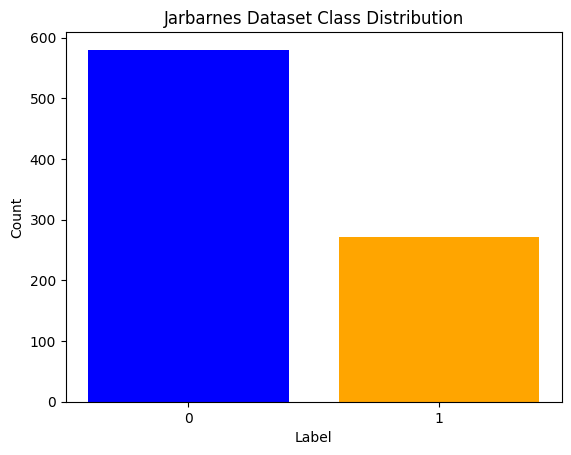

Crowd-Sourced Dataset Class Distribution
Class 1: 885 (55.52%)
Class 0: 709 (44.48%)


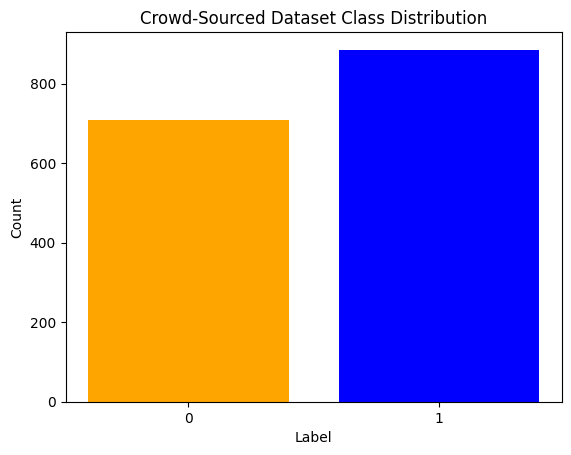

Combined Dataset Class Distribution
Class 0: 1289 (52.72%)
Class 1: 1156 (47.28%)


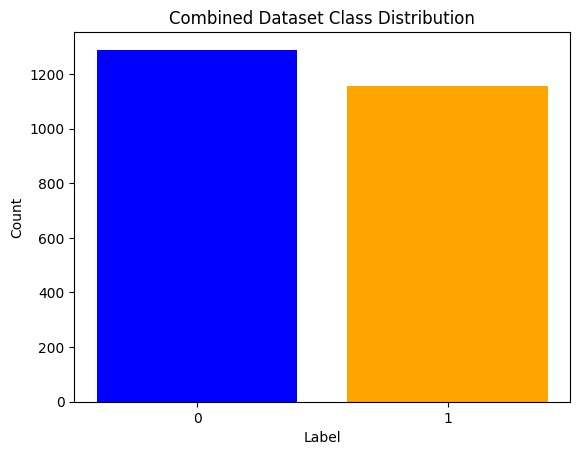

In [14]:
jerbarnes_dataset_path = DATA_DIR/f'jerbarnes_dataset.csv'
jerbarnes_df = pd.read_csv(jerbarnes_dataset_path, header=None, names=['label', 'text', 'processed_text'])
plot_class_distribution(jerbarnes_df, "Jarbarnes Dataset Class Distribution")

crowdsourced_dataset_path = DATA_DIR/f'crowdsourced_dataset.csv'
crowdsourced_df = pd.read_csv(crowdsourced_dataset_path, header=None, names=['label', 'text', 'processed_text'])
plot_class_distribution(crowdsourced_df, "Crowd-Sourced Dataset Class Distribution")

combined_df = pd.concat([jerbarnes_df, crowdsourced_df])
plot_class_distribution(combined_df, "Combined Dataset Class Distribution")